# Una breve introduccion a lo que queremos del curso

Este notebook introduce un ejemplo de lo que queremos que sepan hacer hacia el final del curso. Conceptualmente, el procedimiento es:

*   Explorar los datos (que lo hicieron con Rodrigo)
*   Plantear el problema a resolver
*   Preprocesar los datos a un formato adecuado
*   Elegir algoritmos
*   Fittear y validar
*   Decidir el algoritmo final, y testear




Antes que nada, importamos algunos paquetes

In [ ]:
import numpy as np
import os
import tarfile
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
# to make this notebook's output stable across runs
np.random.seed(42)
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import tree


# Los datos

Vamos a utilizar el dataset de California. Una buena practica es, si los datos lo permiten, separar un conjunto de test que voy a utilizar solamente al final de todo, para evaluar todo lo que hice.

## Si usamos el default de google collab

In [ ]:
california_housing_train=pd.read_csv('sample_data/california_housing_train.csv')
california_housing_test=pd.read_csv('sample_data/california_housing_test.csv')

In [ ]:
california_housing_train.info()

In [ ]:
california_housing_test.info()

## Si usamos el del Geron

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/"
HOUSING_PATH = os.path.join(".", "datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #urllib.request.urlretrieve(housing_url, tgz_path)
    !wget http://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/housing/housing.tgz -P {housing_path}
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing_pre = load_housing_data()

housing_pre["income_cat"] = pd.cut(housing_pre["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(housing_pre, housing_pre["income_cat"]):
    california_housing_train = housing_pre.loc[train_index]
    california_housing_test = housing_pre.loc[test_index]

for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat", axis=1, inplace=True)

URL transformed to HTTPS due to an HSTS policy
--2020-08-11 18:41:29--  https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/housing/housing.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409488 (400K) [application/octet-stream]
Saving to: ‘./datasets/housing/housing.tgz.1’

housing.tgz.1       100%[===================>] 399.89K  --.-KB/s    in 0.06s   

2020-08-11 18:41:30 (6.77 MB/s) - ‘./datasets/housing/housing.tgz.1’ saved [409488/409488]



In [ ]:
california_housing_train.info()

In [ ]:
california_housing_test.info()

## Exploremos los datos (nuevamente)

In [ ]:
housing=california_housing_train.copy()

In [ ]:
housing.hist(bins=50, figsize=(20,15))

In [ ]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
housing.info()

In [ ]:
set(housing["ocean_proximity"].values)

# Preprocesado de datos

El objetivo es poder predecir la mediana del precio de un distrito por sus caracteristicas. Es un problema de regresion univariada supervisada donde mi target es "median_house_value" y mis features son todas las otras categorias.

## Datos colab:

In [ ]:
housing_labels = housing["median_house_value"].copy()
housing_num = housing.drop("median_house_value", axis=1) # drop labels for training set

In [ ]:

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_prepared = num_pipeline.fit_transform(housing_num)



In [ ]:
housing_prepared.head(10)

## Datos Geron:

Voy a separar el target y escalear las variables numericas y re-expresar las categoricas. Combino todo en un pipeline.

In [ ]:
housing_labels = housing["median_house_value"].copy()
# label_scaler=StandardScaler()
# housing_labels_scaled=label_scaler.fit_transform(np.asarray(housing_labels).reshape(-1,1))[:,0]
housing = housing.drop("median_house_value", axis=1) # drop labels for training set
housing_cat = housing[["ocean_proximity"]]
housing_num = housing.drop("ocean_proximity", axis=1)

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),#hay mas opciones aca
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
num_pipeline.fit_transform(housing_num)

In [ ]:
num_pipeline.named_steps['std_scaler'].mean_

In [ ]:
housing_prepared.shape

(16512, 16)

# Regresion

Vamos a resolver el problema. Voy a probar varios algoritmos (sin justificarlos bien, ya los vamos a ver) y evaluar la performance.

## Underfitting con Regresion Lineal

Defino otro Pipeline solo para mostrar, no es estrictamente necesario.

$y = w_0 + \sum_{i=1}^{M}w_{i}\phi_{i}(\vec{x})$

Caso Clase Jueves (y hoy):

$\phi_{i} = x_{i} $

$y = w_0 + \sum_{i=1}^{16}w_{i}x_{i}$

In [ ]:
full_pipeline_with_predictor_lr = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

scores_lr=cross_val_score(full_pipeline_with_predictor_lr, housing, housing_labels,scoring="neg_mean_squared_error", cv=10)#no lo aplico en housing_prepared, no deberia cambiar pero igual
cross_scores_lr = np.sqrt(-scores_lr)

print("Puntajes:", cross_scores_lr)
print("Media:", cross_scores_lr.mean())
print("Desviacion Estandar:", cross_scores_lr.std())

full_pipeline_with_predictor_lr.fit(housing, housing_labels)
predictions_lr=full_pipeline_with_predictor_lr.predict(housing)
print("Ejemplo: ", (round(predictions_lr[100]),housing_labels[100]))
print("MSE Total del conjunto de entrenamiento:", np.sqrt(mean_squared_error(predictions_lr,housing_labels)))

Puntajes: [72498.77894031 67018.92745544 69811.55320864 66736.56591758
 66966.13542574 72935.62934387 67546.8042703  67759.81120117
 70190.77524634 65744.53835569]
Media: 68720.95193650777
Desviacion Estandar: 2376.14777460679
Ejemplo:  (167852.0, 257800.0)
MSE Total del conjunto de entrenamiento: 68382.48122288262


Text(0, 0.5, 'y')

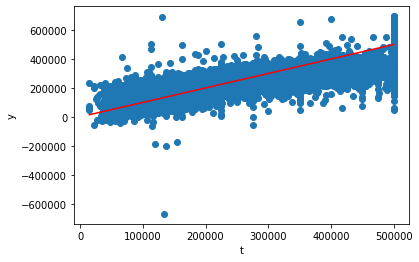

In [ ]:
x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,predictions_lr)
plt.plot(x,x,color='red')
plt.xlabel('t')
plt.ylabel('y')

## Overfitting con Decision Tree

In [ ]:
tree_reg = DecisionTreeRegressor(random_state=42,max_depth=7)#,max_depth=5
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

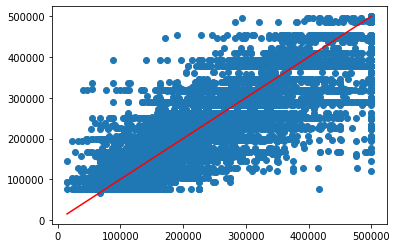

In [ ]:
x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,tree_reg.predict(housing_prepared))
plt.plot(x,x,color='red')

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

58461.14032291324

In [ ]:
tree_reg.get_n_leaves()

32

In [ ]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("Puntajes:", tree_rmse_scores)
print("Media:", tree_rmse_scores.mean())
print("Desviacion Estandar:", tree_rmse_scores.std())

Puntajes: [66125.7862463  62322.41967658 64568.78957814 60488.18028535
 61000.77337508 63218.20055612 61274.40852525 62812.70815589
 61815.38474732 60895.451348  ]
Media: 62452.21024940397
Desviacion Estandar: 1699.6752260838857


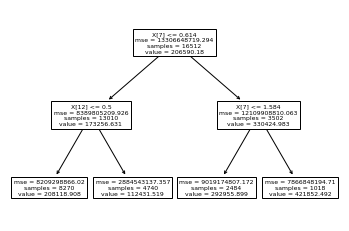

In [ ]:
tree.plot_tree(tree_reg) 
plt.show()

## Fitting con RandomForest

In [ ]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [ ]:
print("Best params:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)


Best params: {'max_features': 6, 'n_estimators': 30}
Best estimator: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [ ]:
cvres = grid_search.cv_results_
for mean_score, std, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), np.sqrt(std),params)

65052.11284727992 15826.66374152429 {'max_features': 2, 'n_estimators': 3}
55472.61008228522 10822.154952235238 {'max_features': 2, 'n_estimators': 10}
53345.32826556834 9880.514134324309 {'max_features': 2, 'n_estimators': 30}
61389.972172833855 11058.523093487302 {'max_features': 4, 'n_estimators': 3}
52982.591934517164 8133.5285799299745 {'max_features': 4, 'n_estimators': 10}
50718.02914370888 7877.502269717471 {'max_features': 4, 'n_estimators': 30}
58529.06122989109 10469.36347317353 {'max_features': 6, 'n_estimators': 3}
52164.336551137945 10823.595907802995 {'max_features': 6, 'n_estimators': 10}
50112.387990928575 10211.496233745886 {'max_features': 6, 'n_estimators': 30}
58417.58787473565 9316.224230945032 {'max_features': 8, 'n_estimators': 3}
52578.63722145321 10431.530708526085 {'max_features': 8, 'n_estimators': 10}
50346.375515195505 9229.161062480387 {'max_features': 8, 'n_estimators': 30}
62574.522994223014 12150.24072892354 {'bootstrap': False, 'max_features': 2, 'n_e

In [ ]:
best_rf=grid_search.best_estimator_
print("Example: ", round(best_rf.predict(housing_prepared)[100]),housing_labels[100])
print("Train MSE: ",np.sqrt(mean_squared_error(best_rf.predict(housing_prepared),housing_labels)))

Example:  150873.0 257800.0
Train MSE:  19329.001591867673


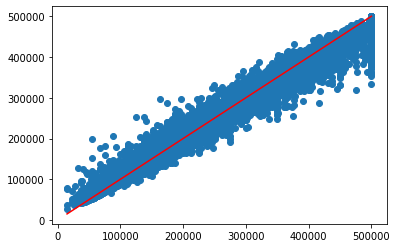

In [ ]:
x=np.linspace(min(housing_labels),max(housing_labels),3)
plt.scatter(housing_labels,best_rf.predict(housing_prepared))
plt.plot(x,x,color='red')

## Una Red Neuronal

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)
keras.backend.clear_session()


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(housing_num, housing_labels, random_state=42)
X_train_proc=num_pipeline.fit_transform(X_train)
X_valid_proc=num_pipeline.transform(X_valid)

In [ ]:
# print(np.asarray(y_train).reshape(-1,1).shape)

scaler = StandardScaler()
y_train_proc = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))
y_valid_proc = scaler.transform(np.asarray(y_valid).reshape(-1,1))


In [ ]:
y_train_proc[:,0].shape

In [ ]:
input_shape = X_train_proc.shape[1:]
batch_size = 128
epochs = 50

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                360       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


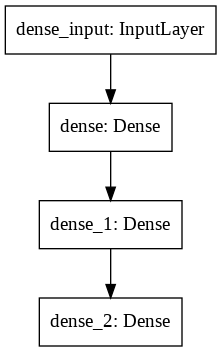

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train_proc, y_train_proc[:,0], epochs=epochs,
                    validation_data=(X_valid_proc, y_valid_proc[:,0]),
                    callbacks=[early_stopping_cb])

Epoch 1/50
387/387 [==============================] - 1s 1ms/step - loss: 0.8806 - val_loss: 0.6888
Epoch 2/50
387/387 [==============================] - 1s 1ms/step - loss: 0.5738 - val_loss: 0.5371
Epoch 3/50
387/387 [==============================] - 1s 2ms/step - loss: 0.4712 - val_loss: 0.4721
Epoch 4/50
387/387 [==============================] - 1s 2ms/step - loss: 0.4240 - val_loss: 0.4386
Epoch 5/50
387/387 [==============================] - 1s 2ms/step - loss: 0.3985 - val_loss: 0.4173
Epoch 6/50
387/387 [==============================] - 1s 1ms/step - loss: 0.3819 - val_loss: 0.4043
Epoch 7/50
387/387 [==============================] - 1s 1ms/step - loss: 0.3701 - val_loss: 0.3917
Epoch 8/50
387/387 [==============================] - 1s 1ms/step - loss: 0.3603 - val_loss: 0.3860
Epoch 9/50
387/387 [==============================] - 0s 1ms/step - loss: 0.3526 - val_loss: 0.3767
Epoch 10/50
387/387 [==============================] - 1s 1ms/step - loss: 0.3452 - val_loss: 0.3709

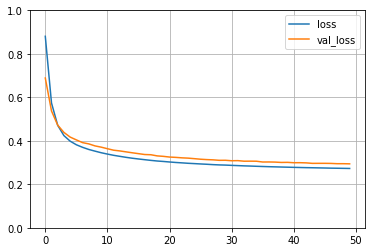

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
mse_train = model.evaluate(X_train_proc, y_train_proc)

387/387 [==============================] - 0s 1ms/step - loss: 0.2719


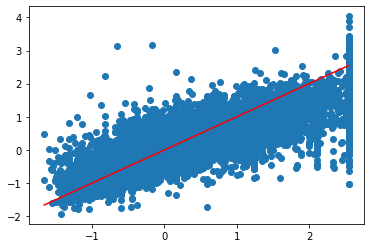

In [ ]:
x=np.linspace(min(y_train_proc[:,0]),max(y_train_proc[:,0]),3)
plt.scatter(y_train_proc[:,0],model.predict(X_train_proc))
plt.plot(x,x,color='red')

In [ ]:
np.sqrt(mean_squared_error(scaler.inverse_transform(model.predict(X_train_proc)),scaler.inverse_transform(y_train_proc)))

60108.64946541966

# Vamos al Test

Esto esta incompleto para llenarlo en clase. Despues de clase subo la version _en vivo_.

In [ ]:
housing_test=california_housing_test.copy()
housing_test["rooms_per_household"] = housing_test["total_rooms"]/housing_test["households"]
housing_test["bedrooms_per_room"] = housing_test["total_bedrooms"]/housing_test["total_rooms"]
housing_test["population_per_household"]=housing_test["population"]/housing_test["households"]

In [ ]:
housing_test_labels = housing_test["median_house_value"].copy()
housing_test = housing_test.drop("median_house_value", axis=1) # drop labels for training set
housing_test_cat = housing_test[["ocean_proximity"]]
housing_test_num = housing_test.drop("ocean_proximity", axis=1)

In [ ]:
housing_test_prepared = full_pipeline.transform(housing_test)

Evaluo el mejor algoritmo: RandomForest

In [ ]:
print("Test MSE: ",np.sqrt(mean_squared_error(best_rf.predict(housing_test_prepared),housing_test_labels)))

Test MSE:  47117.84898400662


# Algunos ejericicios (que pueden ser para dentro de unas clases...)



*   Esta bueno poder mostrar un grafico lindo. En particular, el mapa de latitud y longitud es bastante claro. Juegue con los tres algoritmos que utilizamos pero ahora utilizando como features latitud y longitud. Para cada algoritmo dibuje el mapa y las regiones inferidas de precio utilizando plt.contourf. Por que sugerimos utilizar unicamente dos variables a la hora de entrenar en lugar de utilizar los algoritmos ya entrenados?
*   Reemplaze el GridSearchCV por el RandomizedSearchCV. No se preocupe, lo vamos a ver en detalle mas adelante.
*   Fijese si puede juntar el preprocesado de los datos y los distintos algoritmos en un solo Pipeline. Que hiperparametros tiene? Puede implementarlos en GridSearchCV?


